In [1]:
import os
import re
import nltk
import csv
import pandas as pd     
import numpy as np
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [2]:
# Carrega corpus

loc = '../discursos'
wordLists = PlaintextCorpusReader(loc, '.*\.txt')
print(wordLists.fileids())

['2020-03-03.txt', '2020-03-04.txt', '2020-03-09.txt', '2020-03-10.txt', '2020-04-17.txt', '2020-04-24.txt', '2020-04-29.txt', '2020-05-21.txt', '2020-06-05.txt', '2020-06-08.txt', '2020-06-09.txt', '2020-06-17.txt', '2020-06-22.txt', '2020-06-25.txt', '2020-06-30.txt', '2020-07-02.txt', '2020-07-16.txt', '2020-07-30.txt', '2020-07-31.txt', '2020-08-05.txt', '2020-08-06.txt', '2020-08-11.txt', '2020-08-12.txt', '2020-08-13.txt', '2020-08-14.txt', '2020-08-15.txt', '2020-08-17.txt', '2020-08-18.txt', '2020-08-19.txt', '2020-08-21.txt', '2020-08-24.txt', '2020-08-25.txt', '2020-08-26.txt', '2020-08-27.txt', '2020-08-29.txt', '2020-09-01.txt', '2020-09-02.txt', '2020-09-03.txt', '2020-09-10.txt', '2020-09-11.txt', '2020-09-16.txt', '2020-09-17.txt', '2020-09-18.txt', '2020-09-19.txt', '2020-09-22.txt']


In [3]:
# Carrega stopwords em português

stop_words = stopwords.words('portuguese')

In [4]:
# Carrega discursos para dataframe

fileid_list, text_list, words = [], [], []

for fileid in wordLists.fileids():
    words = [w for w in list(wordLists.words(fileid)) if w.isalpha() and not w.lower() in stop_words]
    text = " ".join(str(elem) for elem in words)
    fileid_list.append(fileid)
    text_list.append(text)
    
df = pd.DataFrame(fileid_list, columns=['filename'])
df['texts'] = text_list

df.head()

,filename,texts
0,2020-03-03.txt,Discurso Presidente República Jair Bolsonaro d...
1,2020-03-04.txt,Discurso Presidente República Jair Bolsonaro d...
2,2020-03-09.txt,Discurso Senhor Presidente República Jair Bols...
3,2020-03-10.txt,Discurso Presidente República Jair Bolsonaro d...
4,2020-04-17.txt,Discurso Presidente República Jair Bolsonaro d...


In [5]:
# Treina modelo

# corpus = pd.read_csv('../corpora/oplexicon_v3.0/lexico_v3.0.csv', sep=',')

# train, words, sentiments = [], [], []

# for index, row in corpus.iterrows():
#     if row['sentiment'] > 0:
#         sentiment = 'pos'
#     elif row['sentiment'] < 0:
#         sentiment = 'neg'
#     else:
#         sentiment = 'neutral'
#     words.append(row['word'])
#     sentiments.append(sentiment)
#     train.append((row['word'], sentiment))
    
# train_set = np.array(train)

# cl = NaiveBayesClassifier(train_set)

# train = []

# with open('../corpora/oplexicon_v3.0/lexico_v3.0.csv') as f:
#     for row in csv.reader(f):
#         train.append(({w: w for w in row[0].split()}, row[2]))

# cl = nltk.NaiveBayesClassifier.train(train)

cl = NaiveBayesClassifier('')


class FeatureDict(object):
    def __iter__(self):
        with open('../corpora/oplexicon_v3.0/lexico_v3.0.csv') as f:
            for row in csv.reader(f):
                yield {w: w for w in row[0].split()}, row[2]

cl.train_features = FeatureDict()
cl.classify('o menino é bom')

'-1'

In [6]:
# Teste para a acurácia
# Trechos criados com palavras presentes no corpus

test = [
    ('Está abrasileirado!', '0'),
    ('o Brasil está abalado', '-1'),
    ('A tecnologia é sofisticada', '1'),
    ('Me sinto humilhado', '-1'),
    ('Temos que ser solidários neste momento', '1'),
    ('Sejamos humildes', '0'),
    ('É tempo de sorrir', '1'),
    ('São todos beneficiários', '0'),
    ('É sofrida esta situação', '-1')
]

In [7]:
# Acurácia do modelo

cl.accuracy(test)

0.3333333333333333

In [8]:
# Características mais informativas do discurso

cl.show_informative_features(15)

Most Informative Features
                   fazer = 'fazer'             1 : 0      =     40.0 : 1.0
                     ter = 'ter'               1 : 0      =     13.8 : 1.0
                   ficar = 'ficar'             1 : -1     =      7.6 : 1.0
                     uma = 'uma'               1 : -1     =      7.1 : 1.0
                  tornar = 'tornar'            1 : 0      =      6.7 : 1.0
                     dar = 'dar'               1 : -1     =      5.9 : 1.0
                      em = 'em'                1 : -1     =      5.0 : 1.0
                   estar = 'estar'             1 : -1     =      5.0 : 1.0
                   sobre = 'sobre'             1 : -1     =      5.0 : 1.0
                       a = 'a'                 1 : -1     =      3.9 : 1.0
                  deixar = 'deixar'            1 : 0      =      3.9 : 1.0
                      ir = 'ir'                1 : 0      =      3.2 : 1.0
                     ser = 'ser'               1 : -1     =      3.0 : 1.0

In [9]:
sentiments, probability_distribution, prob_dist_pos, prob_dist_neg, prob_dist_neutral = [], [], [], [], []

for text in df['texts']:
    sentiments.append(cl.classify(text))
    prob_dist = cl.prob_classify(text)
    probability_distribution.append(prob_dist.max())
    prob_dist_pos.append(round(prob_dist.prob("1"), 2))
    prob_dist_neg.append(round(prob_dist.prob("-1"), 2))
    prob_dist_neutral.append(round(prob_dist.prob("0"), 2))
    
df['sentiment'] = sentiments
df['probability_distribution'] = probability_distribution
df['prob_dist_pos'] = prob_dist_pos
df['prob_dist_neg'] = prob_dist_neg
df['prob_dist_neutral'] = prob_dist_neutral

df.head()

,filename,texts,sentiment,probability_distribution,prob_dist_pos,prob_dist_neg,prob_dist_neutral
0,2020-03-03.txt,Discurso Presidente República Jair Bolsonaro d...,-1,-1,0.27,0.45,0.28
1,2020-03-04.txt,Discurso Presidente República Jair Bolsonaro d...,-1,-1,0.27,0.45,0.28
2,2020-03-09.txt,Discurso Senhor Presidente República Jair Bols...,-1,-1,0.27,0.45,0.28
3,2020-03-10.txt,Discurso Presidente República Jair Bolsonaro d...,-1,-1,0.27,0.45,0.28
4,2020-04-17.txt,Discurso Presidente República Jair Bolsonaro d...,-1,-1,0.27,0.45,0.28


In [10]:
pos = [text for index, text in enumerate(df['texts']) if df['sentiment'][index] == '1']
neg = [text for index, text in enumerate(df['texts']) if df['sentiment'][index] == '-1']
neutral = [text for index, text in enumerate(df['texts']) if df['sentiment'][index] == '0']

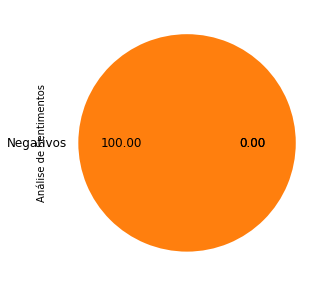

In [11]:
chart = pd.Series((len(pos), len(neg), len(neutral)), index=('Positivos', 'Negativos', 'Neutros'), name='Análise de Sentimentos')
chart.plot.pie(fontsize=12, autopct='%.2f', figsize=(5, 5));